# 6.3 순환 신경망의 고급 사용법
- **순환 드롭아웃**(recurrent dropout) : 순환 층에서 과대적합을 방지하기 위해 케라스에 내장되어 있는 드롭아웃
- **스태킹 순환 층**(stacking recurrent layer) : 네트워크의 표현 능력(representational power)을 증가(계산 비용이 많이 듬)
- **양방향 순환 층**(bidirectional recurrent layer) : 순환 네트워크에 같은 정보를 다른 방향으로 주입하여 정확도를 높이고 기억을 좀 더 오래 유지시킴

## 6.3.1 기온 예측 문제
- 독일 예나(Jena) 시의 막스 플랑크 생물지구화학 연구소의 지상 관측소에서 2009~2016년의 10분마다 기록된 날씨 데이터(기온, 기압, 습도, 풍향 등)를 이용하여 며칠치 데이터를 입력으로 사용, 24시간 이후의 기온을 예측
- [csv 파일](https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip)

### 예나의 날씨 데이터셋 조회하기

In [1]:
import os

data_dir = '../datasets/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [2]:
lines[0]

'01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30'

### 데이터 파싱하기
- 날짜 데이터를 제외한 기상 데이터

In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

### 시계열 온도 그래프 그리기

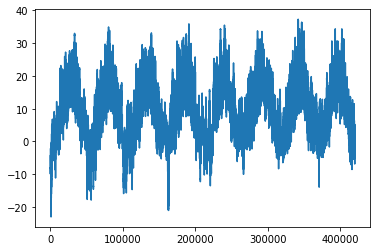

In [4]:
import matplotlib.pyplot as plt

temp = float_data[:, 1] # 섭씨 온도
plt.plot(range(len(temp)), temp)

### 처음 10일간 온도 그래프 그리기
- 10분마다 데이터가 기록되므로 하루 144개, 총 1440개 데이터 (2009년 1월 1일 0시 10분부터 1월 11일 0시 0분까지의 데이터)

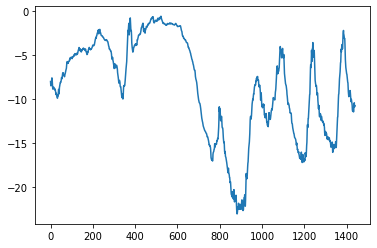

In [6]:
plt.plot(range(1440), temp[:1440])

## 6.3.2 데이터 준비
- lookback 타임스텝만큼 이전으로 돌아가서 매 steps 타임스텝마다 샘플링
- 사용할 변수
    - `lookback = 1440` : 10일 전 데이터로 돌아감
    - `steps = 6` : 1시간마다 데이터 포인트 하나를 샘플링
    - `delay = 144` : 24시간이 지난 데이터가 타깃
- 전처리
    - 신경망에 주입할 수 있는 형태로 전처리. 각 시계열 특성을 개별적으로 정규화하여 비슷한 범위를 가진 작은 값으로 변경
    - 과거 데이터의 배치와 미래 타깃 온도를 추출하는 파이썬 제너레이터 생성
        - 샘플 N과 샘플 N+1은 대부분 타임 스텝이 비슷하기 때문에 메모리 낭비가 심하므로 원본 데이터를 사용하여 그때그때 배치 생성

### 데이터 정규화하기
- 처음 20만 개 타임스텝을 훈련 데이터로 사용할 것이므로 이 데이터의 평균과 표준 편차로 정규화(검증, 테스트 데이터도 이 값으로 정규화)

In [3]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

### 시계열 데이터와 타깃을 반환하는 제너레이터 함수
- shuffle 매개변수
    - 전체 훈련 데이터를 순서대로 학습하는 것보다 랜덤하게 선택한 샘플을 사용하여 가설 공간의 다양성을 탐색하면 지역 최솟값을 벗어나기 쉽고 데이터셋에 과대적합되는 것을 줄일 수 있음
    - 보통은 에포크를 시작하기 전에 전체 데이터셋을 무작위로 섞으나 시계열 데이터이기 때문에 전체를 섞는 대신 임의의 위치에서 시퀀스를 추출

In [4]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    '''
    data : 정규화한 부동 소수 데이터로 이루어진 원본 배열
    lookback : 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
    delay : 타깃으로 사용할 미래의 타임스텝
    min_index, max_index : 추출할 타임스텝의 범위를 지정하기 위한 data 배열의 인덱스. 검증 데이터와 테스트 데이터를 분리하는 데 사용
    shuffle : 샘플을 섞을지, 시간 순서대로 추출할지를 결정
    batch_size : 배치의 샘플 수
    step : 데이터를 샘플링할 타임스텝 간격. 1시간에 하나의 데이터 포인트를 추출하기 위해 6으로 지정
    '''
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

### 훈련, 검증 테스트 제너레이터 준비하기

In [5]:
lookback = 1440 # 특정 날짜로부터 10일만큼 전 데이터를 사용
step = 6 # 10일치 데이터 중 1시간 간격 데이터를 사용
delay = 144 # 특정 날짜로부터 1시간 뒤 데이터를 타겟으로 사용
batch_size = 128

# 처음 20만개 데이터를 훈련 데이터로 사용
train_gen = generator(float_data, lookback=lookback, delay=delay,
                      min_index=0, max_index=200000, shuffle=True,
                      step=step, batch_size=batch_size)

# 그 다음 10만개 데이터를 검증용 데이터로 사용
val_gen = generator(float_data, lookback=lookback, delay=delay,
                    min_index=200001, max_index=300000, shuffle=True,
                    step=step, batch_size=batch_size)

# 나머지를 테스트 데이터로 사용
test_gen = generator(float_data, lookback=lookback, delay=delay,
                     min_index=300001, max_index=None, shuffle=True,
                     step=step, batch_size=batch_size)

# generator 함수는 while문을 사용하여 무한 반복되기 때문에 검증 세트와 테스트 세트를 한 번 순회하는 횟수를 알려 주어야 함
# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## 6.3.3 상식 수준의 기준점
- 정상 여부 확인을 위한 용도이며 고수준 머신 러닝 모델이라면 뛰어넘어야 할 기준점을 만드는 것
- 알려진 해결책이 없는 새로운 문제를 다루어야 할 때 유용
    - 불균형한 분류 문제가 그 예
    - 클래스 A의 샘플이 90%, B의 샘플이 10%일 때 모든 샘플을 A라고 하면 90%의 정확도가 나오므로, 그 이상을 달성해야 좋은 머신러닝 모델
- 온도 데이터의 경우 연속성이 있고 일자별로 주기성을 가진다고 가정할 수 있기 때문에, 상식 수준의 해결책으로 24시간 후 온도는 현재 온도와 동일하다고 예측하는 것

### 상식적인 기준 모델의 MAE 계산하기

In [11]:
def evaluate_naive_model():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_model()

0.2899400196817903


### MAE를 섭씨 단위로 변환하기
- 평균이 0이고 표준 편차가 1이므로 MAE에 표준 편차를 곱함

In [12]:
celsius_mae = 0.28994 * std[1]

In [13]:
celsius_mae

2.5666935838944074

## 6.3.4 기본적인 머신 러닝 방법
- 상식 수준의 기준점을 세운 것처럼, 연산 비용이 적게 드는 기본적인 머신 러닝을 먼저 만들면 이를 바탕으로 더 복잡한 방법을 도입하는 근거가 마련되고 실제적인 이득도 얻게 될 것임

### 완전 연결 모델을 훈련하고 평가하기

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20, 
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 11s 20ms/step - loss: 1.1337 - val_loss: 0.4951
Epoch 2/20
500/500 [==============================] - 10s 20ms/step - loss: 0.3718 - val_loss: 0.2991
Epoch 3/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2869 - val_loss: 0.3255
Epoch 4/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2651 - val_loss: 0.3052
Epoch 5/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2506 - val_loss: 0.3096
Epoch 6/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2427 - val_loss: 0.3286
Epoch 7/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2363 - val_loss: 0.3190
Epoch 8/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2291 - val_loss: 0.3273
Epoch 9/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2254 - val_loss: 0.3269
Epoch 10/20
500/500 [==============================] - 10s 20ms/step - loss: 0.222

### 결과 그래프 그리기

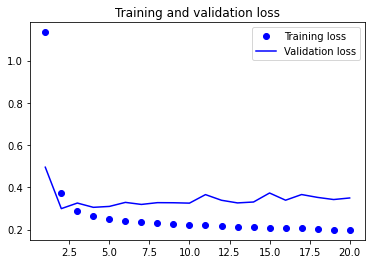

In [15]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

- 앞서 만든 기준을 넘지 못하므로 좋지 않은 모델이라 평가할 수 있음
- 왜 간단한 모델을 찾지 못하는가(뛰어넘지 못하는가)?
    - 가설 공간은 우리가 매개변수로 설정한 2개의 층을 가진 네트워크의 모든 가능한 가중치 조합으로 매우 복잡함
    - 이 복잡한 모델 공간은 간단하고 괜찮은 모델을 찾지 못할 수 있음

## 6.3.5 첫 번째 순환 신경망
- 완전 연결 네트워크는 시계열 데이터를 펼쳤기 때문에 입력 데이터에서 시간 개념을 잃었고 잘 작동하지 않음
- 2014년 정준영 등이 개발한 `GRU` 층 사용
- GRU(Gated Recurrent Unit) 층 : LSTM과 같은 원리로 작동하지만 조금 더 간결하고 계산 비용이 덜 듬(LSTM만큼 표현 학습 능력이 높지 않음)

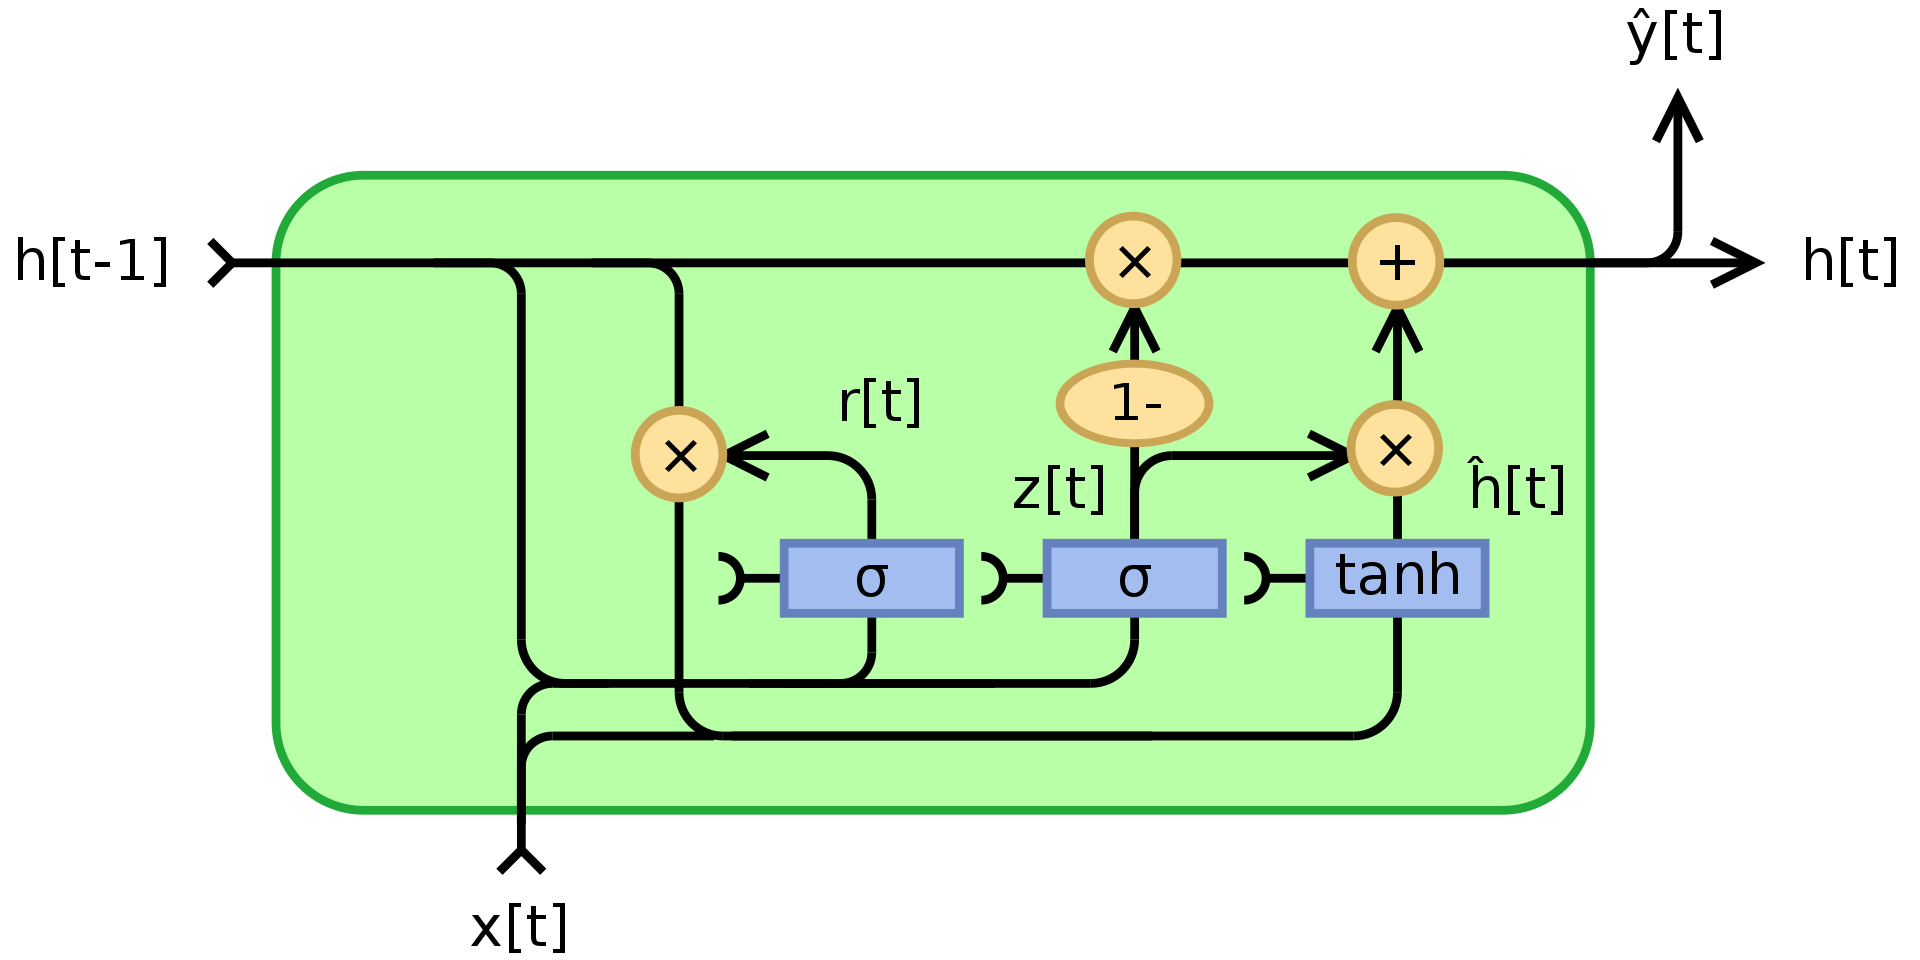
출처 : https://en.wikipedia.org/wiki/Gated_recurrent_unit
```python
output_t = z_t * state_t + (1-z_t) * g_t

z_t = sigmoid(dot(state_t, Uz) + dot(input_t, Wz) + bz)
r_t = sigmoid(dot(state_t, Ur) + dot(input_t, Wr) + br)
g_t = tanh(dot(r_t * state_t, Ug) + dot(input_t, Wg) + bg)
```

### GRU를 사용한 모델을 훈련하고 평가하기

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20,
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 17s 21ms/step - loss: 0.3040 - val_loss: 0.2689
Epoch 2/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2862 - val_loss: 0.2663
Epoch 3/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2794 - val_loss: 0.2671
Epoch 4/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2728 - val_loss: 0.2730
Epoch 5/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2696 - val_loss: 0.2650
Epoch 6/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2636 - val_loss: 0.2676
Epoch 7/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2597 - val_loss: 0.2691
Epoch 8/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2554 - val_loss: 0.2646
Epoch 9/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2493 - val_loss: 0.2737
Epoch 10/20
500/500 [==============================] - 10s 21ms/step - loss: 0.246

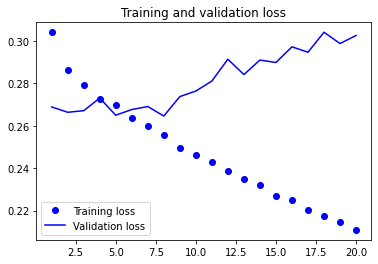

In [7]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

- 상식 수준의 모델보다 좋음 (MAE 2.89보다 작음)
- 그러나 과대적합이 일어남

## 6.3.6 과대적합을 감소하기 위해 순환 드롭아웃 사용하기
- 순환 신경망의 순환 층 이전에 드롭아웃을 적용하면 학습에 더 방해되는 것으로 알려짐
- 2015년 야라니 갈(Yarin Gal)이 베이지안 딥러닝에 관한 논문에서 순환 네트워크에서 드롭아웃을 사용할 방법을 찾아냄
    - 타임스텝마다 랜덤하게 드롭아웃 마스크를 바꾸는 것이 아닌 동일한 드롭아웃 마스크를 모든 타임스텝에 적용하는 것
    - 네트워크가 학습 오차를 타입스텝에 걸쳐 적절하게 전파
- 케라스 순환 층은 2개의 드롭아웃 매개변수를 가짐
    - `dropout` : 층의 입력에 대한 드롭아웃 비율
    - `recurrent_dropout` : 순환 상태의 드롭아웃 비율
- 드롭아웃을 적용한 네트워크는 수렴하는데 더 오래 걸리므로 에포크를 두 배로
- cuDNN을 사용할 수 없기 때문에 시간이 오래 걸림

In [6]:
%%time

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(GRU(32,
              dropout=0.2,
              recurrent_dropout=0.2,
              input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=40,
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 567s 1s/step - loss: 0.3229 - val_loss: 0.2778
Epoch 2/40
500/500 [==============================] - 560s 1s/step - loss: 0.3045 - val_loss: 0.2794
Epoch 3/40
500/500 [==============================] - 561s 1s/step - loss: 0.2962 - val_loss: 0.2750
Epoch 4/40
500/500 [==============================] - 566s 1s/step - loss: 0.2925 - val_loss: 0.2807
Epoch 5/40
500/500 [==============================] - 563s 1s/step - loss: 0.2889 - val_loss: 0.2785
Epoch 6/40
500/500 [==============================] - 559s 1s/step - loss: 0.2841 - val_loss: 0.2752
Epoch 7/40
500/500 [==============================] - 563s 1s/step - loss: 0.2823 - val_loss: 0.2668
Epoch 8/40
500/500 [==============================] - 564s 1s/step - loss: 0.2781 - val_loss: 0.2702
Epoch 9/40
500/500 [==============================] - 563s 1s/step - loss: 0.2732 - val_loss: 0.2700
Epoch 10/40
500/500 [==============================] - 586s 1s/step - loss: 0.2698 - val_lo

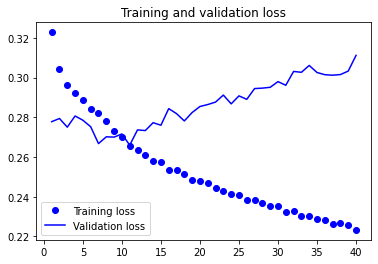

In [7]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

- 딱히 좋아진 걸 모르겠다...

## 6.3.7 스태킹 순환 층
- 과대적합이 일어날 때까지 네트워크의 용량 늘이기
- 구글 번역 알고리즘은 7개 이상의 대규모 LSTM 층을 쌓은 대규모 모델에서 나온 것

### 드롭아웃으로 규제하고 스태킹한 GRU 모델을 훈련하고 평가하기
- `return_seqeunces=True`
- 매우 오래 걸리기 때문에 epoch를 20으로 줄임

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(GRU(32,
              dropout=0.1,
              recurrent_dropout=0.5,
              return_sequences=True,
              input_shape=(None, float_data.shape[-1])))
model.add(GRU(64, activation='relu',
              dropout=0.1,
              recurrent_dropout=0.5))
model.add(Dense(1))

In [10]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, None, 32)          4608      
_________________________________________________________________
gru_4 (GRU)                  (None, 64)                18816     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 23,489
Trainable params: 23,489
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer=RMSprop(), loss='mae')

In [13]:
%%time

history = model.fit(train_gen, steps_per_epoch=500, epochs=20,
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 1268s 3s/step - loss: 0.3145 - val_loss: 0.2887
Epoch 2/20
500/500 [==============================] - 1263s 3s/step - loss: 0.3013 - val_loss: 0.2707
Epoch 3/20
500/500 [==============================] - 1219s 2s/step - loss: 0.2948 - val_loss: 0.2789
Epoch 4/20
500/500 [==============================] - 1220s 2s/step - loss: 0.2876 - val_loss: 0.2808
Epoch 5/20
500/500 [==============================] - 1214s 2s/step - loss: 0.2802 - val_loss: 0.2673
Epoch 6/20
500/500 [==============================] - 1217s 2s/step - loss: 0.2750 - val_loss: 0.2690
Epoch 7/20
500/500 [==============================] - 1213s 2s/step - loss: 0.2700 - val_loss: 0.2728
Epoch 8/20
500/500 [==============================] - 1215s 2s/step - loss: 0.2650 - val_loss: 0.2745
Epoch 9/20
500/500 [==============================] - 1335s 3s/step - loss: 0.2603 - val_loss: 0.2760
Epoch 10/20
500/500 [==============================] - 1352s 3s/step - loss: 0.256

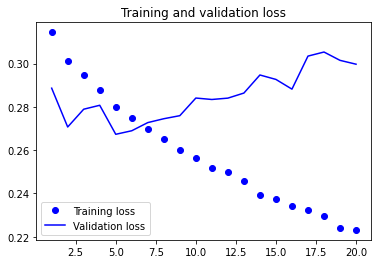

In [14]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

- 검증 데이터 MAE가 0.26 아래로 내려가지 않음 = 향상 정도가 크지 않음
- 층의 크기를 늘려 과대적합을 더 시도 : 계산 비용 증가
- 층을 추가했지만 MAE가 줄어들지 않았다 = 네트워크의 용량을 늘리는 것이 도움이 되지 않음